## Création et visualisation

### imports

In [1]:
import pickle

from graph_authors import run_random_separation, transitivity_by_category
from graph_authors import clean, create_csv, nonDirected_graph, distr_edges_weights, distr_nodes_degree, add_node_attribut_primary_cat
from graph_authors import edge_max, louvain_attribut, visualize_with_pyvis, density_hist_comm_size, are_little_comms_dense, are_big_comms_dense, mean_edges_weight
from graph_authors import first_analysis_giant_connected_component, plyvalent_authors_by_category, bridge_authors_by_centrality, leaders_by_category, analyze_distance_distributions

In [ ]:
import pandas as pd
df = pd.read_csv("articles.csv")


In [ ]:
math_cs_authors = df[df["category"].str.contains("math|cs", case=False, na=False)]["authors"] #len 1120542
math_authors = df[df["category"].str.contains("math.", case=False, na=False)]["authors"] #len 455866 
cs_authors = df[df["category"].str.contains("cs.", case=False, na=False)]["authors"] #len 455866
economy_authors = df[df["category"].str.contains("eco", case=False, na=False)]["authors"] #len 14794

### Créer un dataset des articles en Statistiques, Maths, Economie et Data Science
C'est ce datatset qu'on va utiliser et analyser

In [ ]:
df_science = df[df["category"].str.contains("stat.|math.|econ.|cs.", case=False, na=False)
                & ~df["category"].str.contains("physics|cond-mat", case=False, na=False) & ~
                df["authors"].str.contains("Honghao", case=False, na=False)]
print(df_science.columns)
print(df_science.shape)
df_science.head()

Index(['id', 'title', 'summary', 'category', 'authors', 'published',
       'updated'],
      dtype='object')
(984439, 7)


,id,title,summary,category,authors,published,updated
12,http://arxiv.org/abs/2503.01843v2,When Can You Get Away with Low Memory Adam?,Adam is the go-to optimizer for training moder...,cs.LG,"Dayal Singh Kalra, John Kirchenbauer, Maissam ...",2025-03-03T18:59:40Z,2025-03-06T18:38:33Z
16,http://arxiv.org/abs/2502.21269v1,Dynamical Decoupling of Generalization and Ove...,The inductive bias and generalization properti...,stat.ML,"Andrea Montanari, Pierfrancesco Urbani",2025-02-28T17:45:26Z,2025-02-28T17:45:26Z
31,http://arxiv.org/abs/2502.18964v1,Variational representation and estimates for t...,Random walks with a disordered self-interactio...,math.PR,Julien Poisat,2025-02-26T09:22:14Z,2025-02-26T09:22:14Z
38,http://arxiv.org/abs/2502.18553v2,Applications of Statistical Field Theory in De...,Deep learning algorithms have made incredible ...,stat.ML,"Zohar Ringel, Noa Rubin, Edo Mor, Moritz Helia...",2025-02-25T18:19:06Z,2025-02-28T07:45:02Z
66,http://arxiv.org/abs/2502.10390v1,(How) Can Transformers Predict Pseudo-Random N...,Transformers excel at discovering patterns in ...,cs.LG,"Tao Tao, Darshil Doshi, Dayal Singh Kalra, Tia...",2025-02-14T18:59:40Z,2025-02-14T18:59:40Z


In [89]:
# Affiche le nombre de lignes où un nom apparaît plusieurs fois dans la même liste d'auteurs
def has_duplicate_author(authors_str):
    authors = [a.strip() for a in authors_str.split(",")]
    return len(authors) != len(set(authors))

nb_duplicates = df["authors"].apply(has_duplicate_author).sum()
# Supprimer les lignes où un nom apparaît plusieurs fois dans la même liste d'auteurs
mask_no_duplicates = ~df_science["authors"].apply(has_duplicate_author)
df_science = df_science[mask_no_duplicates]

# Supprimer les lignes avec des résumés (summary) identiques (on garde la première occurrence)
df_science = df_science.drop_duplicates(subset="summary", keep="first")
print(f"Après nettoyage : {len(df_science)} lignes restantes.")


Après nettoyage : 694794 lignes restantes.


In [42]:
df_science.head(8)

,id,title,summary,category,authors,published,updated
12,http://arxiv.org/abs/2503.01843v2,When Can You Get Away with Low Memory Adam?,Adam is the go-to optimizer for training moder...,cs.LG,"Dayal Singh Kalra, John Kirchenbauer, Maissam ...",2025-03-03T18:59:40Z,2025-03-06T18:38:33Z
16,http://arxiv.org/abs/2502.21269v1,Dynamical Decoupling of Generalization and Ove...,The inductive bias and generalization properti...,stat.ML,"Andrea Montanari, Pierfrancesco Urbani",2025-02-28T17:45:26Z,2025-02-28T17:45:26Z
31,http://arxiv.org/abs/2502.18964v1,Variational representation and estimates for t...,Random walks with a disordered self-interactio...,math.PR,Julien Poisat,2025-02-26T09:22:14Z,2025-02-26T09:22:14Z
38,http://arxiv.org/abs/2502.18553v2,Applications of Statistical Field Theory in De...,Deep learning algorithms have made incredible ...,stat.ML,"Zohar Ringel, Noa Rubin, Edo Mor, Moritz Helia...",2025-02-25T18:19:06Z,2025-02-28T07:45:02Z
66,http://arxiv.org/abs/2502.10390v1,(How) Can Transformers Predict Pseudo-Random N...,Transformers excel at discovering patterns in ...,cs.LG,"Tao Tao, Darshil Doshi, Dayal Singh Kalra, Tia...",2025-02-14T18:59:40Z,2025-02-14T18:59:40Z
81,http://arxiv.org/abs/2502.07998v1,Adaptive kernel predictors from feature-learni...,Previous influential work showed that infinite...,cs.LG,"Clarissa Lauditi, Blake Bordelon, Cengiz Pehlevan",2025-02-11T22:34:49Z,2025-02-11T22:34:49Z
84,http://arxiv.org/abs/2502.06739v1,A note on the physical interpretation of neura...,We highlight a formal and substantial analogy ...,cs.LG,Sauro Succi,2025-02-10T18:07:51Z,2025-02-10T18:07:51Z
87,http://arxiv.org/abs/2502.05300v1,Parameter Symmetry Breaking and Restoration De...,The dynamics of learning in modern large AI sy...,cs.LG,"Liu Ziyin, Yizhou Xu, Tomaso Poggio, Isaac Chuang",2025-02-07T20:10:05Z,2025-02-07T20:10:05Z


### Create a CSV with collaboration authors from stats, maths, computer science and economy
Columns: "author1", "author2", "weight", "category"

In [ ]:
create_csv("science_collaboration_cat&wight.csv", df_science)

CSV sauvegardé sous « science_collaboration_cat&wight.csv »


In [ ]:
from IPython.display import SVG
from sknetwork.data import from_edge_list, from_adjacency_list, from_graphml, from_csv
from sknetwork.visualization import visualize_graph, visualize_bigraph
from sknetwork.clustering import Louvain, get_modularity
from networkx.algorithms.community import louvain_communities
from collections import Counter, defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as c
from networkx.algorithms import community 
import numpy as np
import csv, unicodedata
from itertools import combinations
from pyvis.network import Network
from networkx import density
import random    
from itertools import combinations


def clean(name: str) -> str:
    n = unicodedata.normalize("NFKC", name.strip())
    n = " ".join(n.split())
    return n

def create_csv(name, dataset):
    """ Create a CSV file with co-authorship data.
     4 columns: author1, author2, weight, category """
    conditions = [
        dataset["category"].str.contains("stat\\.", case=False, na=False),
        dataset["category"].str.contains("math\\.", case=False, na=False),
        dataset["category"].str.contains("cs\\.",   case=False, na=False),
        dataset["category"].str.contains("econ\\.", case=False, na=False)
    ]
    choices = ["stat", "math", "cs", "econ"]
    dataset["category"] = np.select(conditions, choices, default=dataset["category"])

    coauthor_counts = defaultdict(int)

    for i, authors in enumerate(dataset["authors"]):
        category = dataset["category"].iat[i]
        authors_set = {clean(a) for a in authors.split(",") if a.strip()}
        for a1, a2 in combinations(sorted(authors_set), 2):
            coauthor_counts[(a1, a2, category)] += 1

    with open(name, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["author1", "author2", "weight", "category"])
        for (a1, a2, cat), w in coauthor_counts.items():
            writer.writerow([a1, a2, w, cat])

    print(f"CSV sauvegardé sous « {name} »")


def nonDirected_graph(file, filter_weight=None, samples=None):
    ''' Create a Graph from
    file: collaboration csv with 4 columns: author1, author2, weight, category
    filter_weight: if we want to display only authors that have more than filter_weight collaborations
    samples: if the csv is too heavy, use only some samples taken randomly from the dataset
    '''
    df = pd.read_csv(file)

    # eliminate lines which weight isn't relevant
    if filter_weight is not None:
        df_filtered = df[df["weight"] > filter_weight]
        df = df_filtered
    
    # take randomly n samples
    if samples is not None:
        df_sample = df.sample(n=samples, random_state=42)  # random_state for reproducibility
        df = df_sample

    # Create non-directed graph
    G = nx.Graph()

    # Add weight and category as attributes to the edges
    for _, row in df.iterrows():
        G.add_edge(row["author1"], row["author2"], weight=row["weight"], category=row["category"])
        
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    
    return G


def distr_edges_weights(G):
    """
    Fonction pour afficher la distribution des poids des arêtes d'un graphe.
    """

    # 1. Récupérer tous les poids des arêtes
    weights = [edata['weight'] for _, _, edata in G.edges(data=True)]

    # 2. Compter combien de fois chaque poids apparaît
    weight_counts = Counter(weights)

    # 3. Trier les poids et leurs fréquences
    weights, counts = zip(*sorted(weight_counts.items()))

    # 4. Tracer l'histogramme
    plt.figure(figsize=(8, 5))
    plt.bar(weights, counts, log=True)  # Utiliser une échelle logarithmique pour l'axe Y
    plt.xlabel("Poids (weight)")
    plt.ylabel("Nombre d'arêtes (log scale)")
    plt.title("Distribution des poids des arêtes")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def distr_nodes_degree(G, w=False):
    """
    Affiche la distribution des degrés des noeuds du graphe G.
    w=False pour afficher la distribution des degrés (càd le nombre de voisins)
    w=True pour afficher la distribution des poids pondérés (càd le nombre d'articles publiés)
    """
    # Distribution des degrés des noeuds
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if w==False:
        v = "(voisins)"
    else:
        v = "pondérés (nombre de publications)"

    # Histogramme avec échelle normale (à gauche)
    axes[0].hist(degree_sequence, bins=50, color='green', alpha=0.7)
    axes[0].axvline(np.mean(degree_sequence), color='red', linestyle='--', label=f'Moyenne: {np.mean(degree_sequence):.2f}')
    axes[0].set_xlabel("Degré (degree)")
    axes[0].set_ylabel("Nombre de noeuds (nodes)")
    axes[0].set_title("Distribution des degrés, ",v," des noeuds (échelle normale)")
    axes[0].grid(True, linestyle="--", alpha=0.5)
    axes[0].legend()

    # Histogramme avec échelle logarithmique (à droite)
    axes[1].hist(degree_sequence, bins=50, color='green', alpha=0.7, log=True)  # Log scale for y-axis
    axes[1].axvline(np.mean(degree_sequence), color='red', linestyle='--', label=f'Moyenne: {np.mean(degree_sequence):.2f}')
    axes[1].axvline(np.median(degree_sequence), color='purple', linestyle='--', label=f'Médiane: {np.median(degree_sequence):.2f}')
    axes[1].set_xscale('log')  # Log scale for x-axis
    axes[1].set_xlabel("Degré (degree) [log scale]")
    axes[1].set_ylabel("Nombre de noeuds (nodes) [log scale]")
    axes[1].set_title("Distribution des degrés ", v ," (voisins) des noeuds (échelle logarithmique)")
    axes[1].grid(True, linestyle="--", alpha=0.5)
    axes[1].legend()

    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.show()

def add_node_attribut_primary_cat(G):
    """ Ajouter l'attribut 'primary_category' à chaque noeud du graphe G"""
    primary_cat = {}
    for node in G:
        cats = [edata['category'] for _, _, edata in G.edges(node, data=True)]
        if cats:
            primary_cat[node] = Counter(cats).most_common(1)[0][0] # example: primary_cat[node] = 'cs'
        else:
            primary_cat[node] = None
    nx.set_node_attributes(G, primary_cat, 'primary_category')
    return primary_cat

def edge_max(G, primary_cat):
    """Trouver l'arête avec le poids maximal"""
    max_weight = max([edata['weight'] for _, _, edata in G.edges(data=True)])
    for u, v, edata in G.edges(data=True):
        if edata['weight'] == max_weight:
            print(f"Les deux auteurs connectés par l'arête de poids maximal ({max_weight}) sont : '{u}' et '{v}'")
            # leur degré
            print(f"Leur degré, càd le nombre de publications est : {G.degree(u, weight='weight')}, {G.degree(v, weight='weight')}")
            print("leur catégorie principale:")
            print(primary_cat[u], primary_cat[v])
            break

def louvain_attribut(G, res=1.0):
    """ Run louvain algorith
    communities c'est une liste d'ensembles, chaque ensemble est composé des auteurs de la communauté: [{"john", "clara"}, {"jane",...}, ...]
    membership c'est un dictionnaire qui associe chaque auteur à sa communauté: {"john" : 0, "clara" : 0, "jane": 1, ...}
    ajouter un attribut à chaque noeud du graphe: la communauté à laquelle il appartient"""
    communities = louvain_communities(G, weight='weight', resolution=res) 

    membership = {node: cid for cid, comm in enumerate(communities) for node in comm}
    nx.set_node_attributes(G, membership, 'louvain_community')

    #Print the number of communities
    print(f"Number of communities: {len(communities)}")

    return communities, membership

def visualize_with_pyvis(G, output_file='network.html'):
    """
    Create an interactive visualization of the network using pyvis
    
    Parameters:
    G (nx.Graph): NetworkX graph object
    output_file (str): Name of the HTML file to save the visualization
    """
    # Create a pyvis network
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='remote')
    
    # Get weights for edge scaling
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    
    # Add nodes and edges to the pyvis network
    for node in G.nodes():
        net.add_node(node, size=10, title=node)
    
    # 3. Add edges with exact weights as widths
    for u, v in G.edges():
        weight = G[u][v]['weight']
        # Scale width (1-10) based on weight
        #width = 1 + 9 * (weight / max_weight)
        net.add_edge(u, v, value=weight, width=weight, title=f"Collaborations: {weight}")
    
    
    # Scale node size by degree:
    degrees = dict(G.degree())
    for node in net.nodes:
        node['size'] = 5 + degrees[node['id']]  # Scale size by degree

    # Color nodes by community:
    communities = community.greedy_modularity_communities(G)
    for i, com in enumerate(communities):
        for node in com:
            net.get_node(node)['color'] = f'hsl({i*60}, 100%, 50%)'

    # Configure physics for better layout
    net.set_options("""
    {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -80000,
          "centralGravity": 0.3,
          "springLength": 200,
          "springConstant": 0.04,
          "damping": 0.09,
          "avoidOverlap": 0.1
        },
        "minVelocity": 0.75
      }
    }
    """)
    
    # Save and show the network
    net.show(output_file)
    return net


def density_hist_comm_size(membership):
    """histogramme de densité des tailles des communautés"""
    community_sizes = Counter(membership.values())
    plt.figure(figsize=(10, 6))
    plt.hist(list(community_sizes.values()), bins=150,  color='skyblue', edgecolor='black')
    plt.xlabel('Taille de la communauté')
    plt.ylabel('Nombre de communnautés')
    plt.title('Distribution de la taille des communautés')
    plt.yscale('log')  # Use log scale for better visualization if there are large differences
    plt.show()



def are_little_comms_dense(G,communities,membership, t):
    """Vérifier la densité des petites communautés (<10 nœuds)
    Densité = 2m/n(n-1) où m est le nombre d'arêtes et n le nombre de nœuds"""
    small_communities = [comm for comm in communities if len(comm) < 10]

    # Seuil pour définir une communauté dense (modifiable)
    t = 0.99
    dens=0
    results = []
    for comm in small_communities:
        subg = G.subgraph(comm)
        d = density(subg)
        # Récupère l'ID de la communauté à partir d'un de ses nœuds
        cid = membership[next(iter(comm))]
        results.append((cid, len(comm), d, d > t))
        if d> t:
            dens+=1

    # Calculer la fréquence (probabilité) d'être dense parmi les petites communautés
    freq_dense = dens / len(small_communities) if small_communities else 0
    print(f"Nombre de petites communautés (<10): {len(small_communities)}")
    print(f"Nombre de communautés denses (densité > {t}): {dens}")
    print(f"Probabilité (fréquence) d'être dense : {freq_dense:.2%}")
    print(f"threshold: {t}")

    # Afficher un camembert pour visualiser la proportion
    plt.figure(figsize=(5, 5))
    plt.pie([dens, len(small_communities) - dens],
        labels=['Denses', 'Non denses'],
        autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62'])
    plt.title(f"Proportion de petites communautés denses (<10 nœuds)")
    plt.show()

def are_big_comms_dense(G,communities,membership, t):
    """Vérifier la densité des petites communautés (<10 nœuds)
    Densité = 2m/n(n-1) où m est le nombre d'arêtes et n le nombre de nœuds"""
    big_communities = [comm for comm in communities if len(comm) > 100]

    # Seuil pour définir une communauté dense (modifiable)
    t = 0.99
    dens=0
    results = []
    for comm in big_communities:
        subg = G.subgraph(comm)
        d = density(subg)
        # Récupère l'ID de la communauté à partir d'un de ses nœuds
        cid = membership[next(iter(comm))]
        results.append((cid, len(comm), d, d > t))
        if d> t:
            dens+=1

    # Calculer la fréquence (probabilité) d'être dense parmi les petites communautés
    freq_dense = dens / len(big_communities) if big_communities else 0
    print(f"Nombre de petites communautés (<10): {len(big_communities)}")
    print(f"Nombre de communautés denses (densité > {t}): {dens}")
    print(f"Probabilité (fréquence) d'être dense : {freq_dense:.2%}")
    print(f"threshold: {t}")

    # Afficher un camembert pour visualiser la proportion
    plt.figure(figsize=(5, 5))
    plt.pie([dens, len(big_communities) - dens],
        labels=['Denses', 'Non denses'],
        autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62'])
    
    plt.title(f"Proportion de grandes communautés denses (>100 nœuds)")
    plt.show()

def mean_edges_weight(G, communities, size, little=False):
    """Calculer le poids moyen des arêtes des communautés de taille > size si little =False et de taille < size si little = True"""

    community_means = []
    community_ids = []

    for cid, comm in enumerate(communities):
        if little:
            if len(comm) < size:
                subg = G.subgraph(comm)
                weights = [edata['weight'] for _, _, edata in subg.edges(data=True)]
                mean_weight = np.mean(weights) if weights else 0
                community_means.append(mean_weight)
                community_ids.append(cid)
            v = "<"
        else:
            if len(comm) > size:
                subg = G.subgraph(comm)
                weights = [edata['weight'] for _, _, edata in subg.edges(data=True)]
                mean_weight = np.mean(weights) if weights else 0
                community_means.append(mean_weight)
                community_ids.append(cid)
            v = ">"

    plt.figure(figsize=(10, 5))
    plt.scatter(community_ids, community_means, alpha=0.7)
    plt.xlabel("ID de la communauté")
    plt.ylabel("Poids moyen des arêtes")
    plt.title("Poids moyen des arêtes pour les communautés (",v,size,")")
    plt.grid(True, linestyle="--", alpha=0.5)

    # Ajout de la moyenne sur l'axe des y
    mean_y = np.mean(community_means)
    plt.axhline(mean_y, color='red', linestyle='--', label=f'Moyenne: {mean_y:.2f}')
    plt.axhline(np.median(community_means), color='green', linestyle='--', label=f'Médiane: {np.median(community_means):.2f}')
    plt.legend()

    plt.show()

def first_analysis_giant_connected_component(G):

    """ return: Gg un sous-graphe du plus grand composant connexe de G
    La proportion des noeuds de G qui composent le plus grand composant connexe
    La moyenne des poids des arêtes de ce composant"""

    giant = max(nx.connected_components(G), key=len)
    Gg = G.subgraph(giant)
    relative_size = Gg.number_of_nodes() / G.number_of_nodes()
    print(f"Taille relative du plus grand composant connexe :{Gg.number_of_nodes()} / {G.number_of_nodes()} = {relative_size:.4f}")
    mean_weight_giant = np.mean([edata['weight'] for _, _, edata in Gg.edges(data=True)])
    print(f"Moyenne des poids des arêtes de la composante géante : {mean_weight_giant:.4f}")
    return Gg

def plyvalent_authors_by_category(G, primary_cat):
    """ Trouver les auteurs qui sont des ponts entre les catégories
    (càd qui ont le plus d'arêtes avec des catégories différentes de la leur)"""
    bridge_score = {}
    for node in G:
        pc = primary_cat[node]
        # count edges whose category ≠ this node’s primary_category
        cross = sum(1 for _, _, ed in G.edges(node, data=True)
                    if ed['category'] != pc)
        bridge_score[node] = cross
    best_bridges = defaultdict(lambda: (None, -1))

    for node, score in bridge_score.items():
        pc = primary_cat[node]
        if node==' Jr.':
            continue 
        # this author’s score bigger than the current stored best score for that category
        if pc and score > best_bridges[pc][1]:
            best_bridges[pc] = (node, score)

    # Show results
    for cat, (author, score) in best_bridges.items():
        print(f"Category '{cat}': bridge author = {author!r} with {score} cross‐category edges and in community {G.nodes[author]['louvain_community']}")


def bridge_authors_by_centrality(G, primary_cat):
    cats = sorted({c for c in primary_cat.values() if c is not None})

    all_nodes = list(G.nodes())
    sample_nodes = set(random.sample(all_nodes, 900000))

    # Création du sous‐graphe induit (et copie pour avoir un graphe indépendant)
    G_sub = G.subgraph(sample_nodes)
    # PERSONNES-PONT entre chaque paire (A→B) : 
    # auteurs de A avec le PLUS de voisins dans B et un betweenness élevé.
    betw = nx.betweenness_centrality(G_sub, weight='weight')

    bridges = {}
    for c1, c2 in combinations(cats, 2):
        # candidats dans c1 → voisins dans c2
        scores = []
        for u in G_sub.nodes:
            if primary_cat.get(u) != c1:
                continue
            nbrs_in_c2 = sum(1 for v in G_sub[u] if primary_cat.get(v)==c2)
            if nbrs_in_c2>0:
                scores.append((u, nbrs_in_c2, betw[u]))
        # Triez d’abord par voisins (desc), puis par betw (desc)
        scores.sort(key=lambda x: (x[1], x[2]), reverse=True)
        if scores:
            u, nbrs, b = scores[0]
            bridges[(c1,c2)] = (u, nbrs, b)

    print(">>> Personnes-pont (A→B) : (auteur, #voisins_B, betweenness)")
    for (c1,c2), (u,nv,b) in bridges.items():
        print(f"  {c1:>6}→{c2:<6} : {u!r}, voisins={nv}, betw={b:.4f}")


def leaders_by_category(G, primary_cat, degree=True, betw=False ):
    """ Cherche des leaders par catégorie
        degree=True : extrait le sous-graphe de chaque catégorie et prend le nœud de degré pondéré maximal.
        betw=True: Betweenness : même chose mais avec la mesure de betweenness sur chaque sous-graphe."""

    cats = sorted({c for c in primary_cat.values() if c is not None})

    if degree:
        # LEADERS par catégorie par centralité de degré (pondéré)
        leaders_deg = {}
        for c in cats:
            sub = G.subgraph([u for u in G if primary_cat.get(u)==c])
            # degree pondéré
            deg = sub.degree(weight='weight')
            u, d = max(deg, key=lambda x: x[1])
            leaders_deg[c] = (u, d)

        print("\n>>> Leaders par degré (catégorie: auteur, degré_pondéré)")
        for c, (u,d) in leaders_deg.items():
            print(f"  {c:>8} : {u!r}, degré={d}")
    else:
        leaders_deg = None
    if betw==True:
        # Leaders par catégorie par betweenness dans chaque sous-graphe
        leaders_btw = {}
        for c in cats:
            sub = G.subgraph([u for u in G if primary_cat.get(u)==c])
            btw_sub = nx.betweenness_centrality(sub, weight='weight')
            u, b = max(btw_sub.items(), key=lambda x: x[1])
            leaders_btw[c] = (u, b)

        print("\n>>> Leaders par betweenness (catégorie: auteur, betweenness)")
        for c, (u,b) in leaders_btw.items():
            print(f"  {c:>8} : {u!r}, betw={b:.4f}")
    else:
        leaders_deg = None
    return leaders_deg


def analyze_distance_distributions(G, primary_cat, leaders_deg, n_samples=1000):
    """
    Pour G (avec node attr primary_category) :
      1) Distance random_intra : pour chaque catégorie, on tire n_samples paires
         (u,v) dans la même catégorie, calcule leur distance, trace et moyenne.
      2) Distance random_any : on tire n_samples paires de nœuds au hasard dans G,
         calcule leur distance, trace et moyenne.
    leaders_deg doit être un dict {cat: (leader_node, deg)}.
    """
    # Préparation : on travaillera sur le plus grand composant pour éviter les isolés
    comp0 = max(nx.connected_components(G), key=len)
    G0 = G.subgraph(comp0).copy()
    nodes0 = list(G0.nodes())
    
    # 1) random intra-cat
    fig, axes = plt.subplots(1, len(leaders_deg), figsize=(4*len(leaders_deg), 4))
    if len(leaders_deg)==1: axes = [axes]
    for ax, cat in zip(axes, leaders_deg):
        authors = [u for u in G0 if primary_cat.get(u)==cat]
        pairs = [random.sample(authors, 2) for _ in range(n_samples)]
        dists = []
        for u,v in pairs:
            try:
                dists.append(nx.shortest_path_length(G0, u, v))
            except nx.NetworkXNoPath:
                pass
        ax.hist(dists, bins=20)
        ax.axvline(sum(dists)/len(dists), color='k', linestyle='--')
        ax.set_title(f"Random intra {cat}\nmean={sum(dists)/len(dists):.2f}")
        ax.set_xlabel('Distance')
        ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

    # 2) random any
    pairs = [random.sample(nodes0, 2) for _ in range(n_samples)]
    dists = []
    for u,v in pairs:
        try:
            dists.append(nx.shortest_path_length(G0, u, v))
        except nx.NetworkXNoPath:
            pass
    plt.figure(figsize=(5,4))
    plt.hist(dists, bins=20)
    plt.axvline(sum(dists)/len(dists), color='k', linestyle='--')
    plt.title(f"Random any-category\nmean={sum(dists)/len(dists):.2f}")
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def run_random_separation(G, runs=10, max_deg=8, seed=None, plot=True):
    """
    Pour `runs` nœuds aléatoires dans le grand composant de G, calcule la taille
    cumulée de l'ensemble atteint à chaque degré de séparation (1..max_deg).
    Si plot=True, trace les `runs` courbes cumulatives pour comparer les profils.
    """
    if seed is not None:
        random.seed(seed)
    # grand composant
    comp0 = max(nx.connected_components(G), key=len)
    G0 = G.subgraph(comp0)
    nodes = list(G0.nodes())
    # tirage aléatoire de `runs` nœuds dans le grand composant
    starts = random.sample(nodes, runs)
    
    profiles = {}
    for s in starts:
        visited = {s}
        frontier = {s}
        cum_counts = []
        for d in range(1, max_deg + 1):
            #voisins de frontier
            neigh = set(nb for u in frontier for nb in G0.neighbors(u))
            # ne garder que les nouveaux
            new_front = neigh - visited
            visited |= new_front
            cum_counts.append(len(visited))
            frontier = new_front
            if not frontier:
                break
        profiles[s] = cum_counts

    if plot:
        plt.figure()
        for s, cum in profiles.items():
            plt.plot(range(1, len(cum) + 1), cum, marker='o', label=str(s))
        plt.xlabel('Degré de séparation')
        plt.ylabel('Nombre cumulatif d’auteurs atteints')
        plt.title('Profils de séparation pour 10 démarrages aléatoires')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return profiles


def transitivity_by_category(G, primary_cat):
    """ TRANSITIVITÉ (global clustering) par catégorie"""
    cats = sorted({c for c in primary_cat.values() if c is not None})
    trans = {}
    for c in cats:
        sub = G.subgraph([u for u in G if primary_cat.get(u)==c])
        trans[c] = nx.transitivity(sub)

    print("\n>>> Transitivité (2m/[n(n-1)]) par catégorie")
    for c, t in trans.items():
        print(f"  {c:>8} : {t:.4f}")



### Create a networks non directed graph of a csv authors
    - fonction qui crée le graph
    - histogramme de la distrubution du poids des arrêtes
    - histogramme de la distribution des degrés des noeuds (somme des poids de ses arrêtes)


In [ ]:
#Graph with all the authors (even if they have only one collaboration)
G_science= nonDirected_graph("science_collaboration_cat&wight.csv", filter_weight=0) 


# Save the object graph in a pickle file for later use
with open('G_science.pkl', 'wb') as f:
    pickle.dump(G_science, f)

Number of nodes: 581712
Number of edges: 3195437


In [102]:
print(f"Number of nodes: {G_science.number_of_nodes()}")
print(f"Number of edges: {G_science.number_of_edges()}")

Number of nodes: 581712
Number of edges: 3195437


In [2]:
import pickle

with open('G_science.pkl', 'rb') as f:
    G_science = pickle.load(f) 

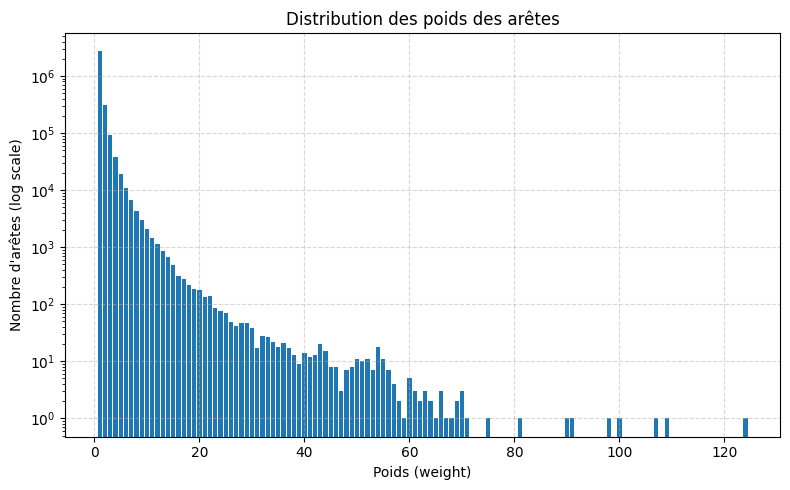

In [ ]:
distr_edges_weights(G_science)


Conlusion: essayer de trouver la structure simplifiée avec des arbres couvrants ne va pas être cohérent cohérent puisque avec un **MST** on obtient le squelette qui relie tous les auteurs en passant systématiquement par la collaboration la plus forte disponible à chaque embranchement. Un auteur très connecté ( la plupart de ses arrêtes de poids >3) peut aspirer beaucoup de branches dans l’arbre, donnant une structure en étoile trompeuse.
Suite: on va plutot chercher des structures de **communautés et de centralité**


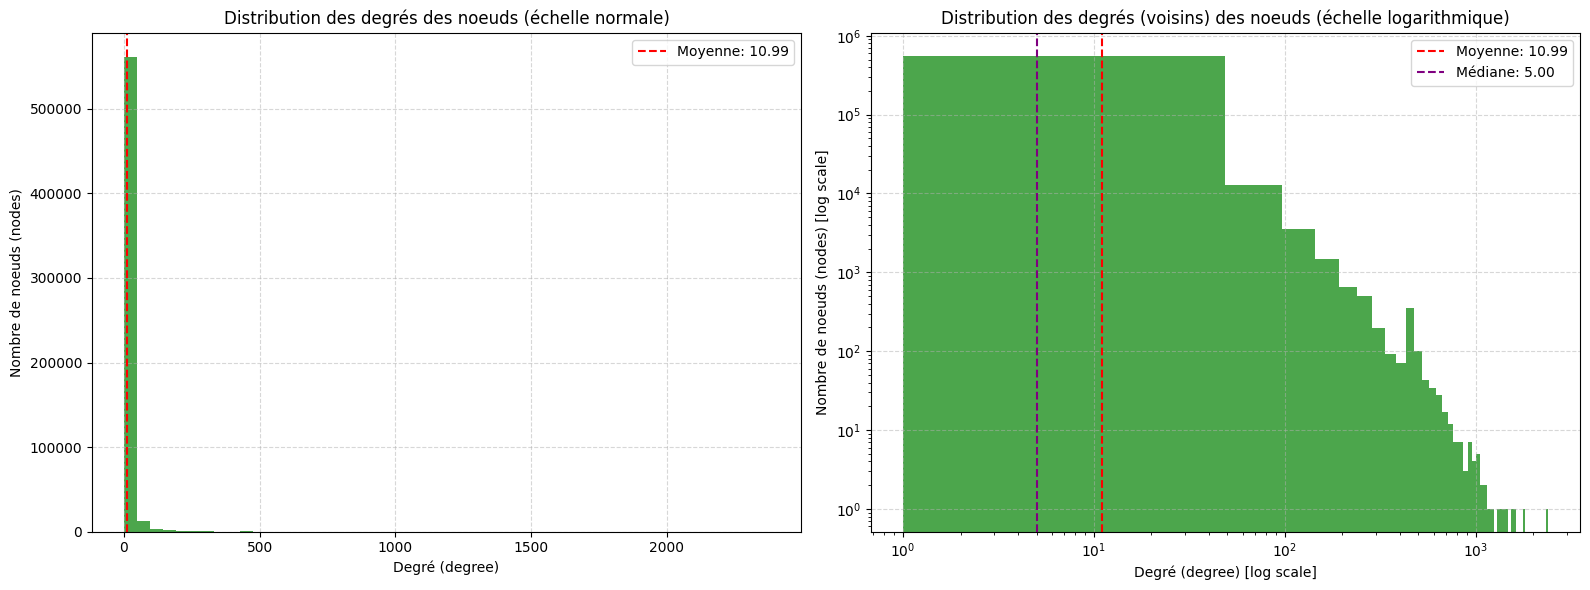

In [ ]:
distr_nodes_degree(G_science, w=False)

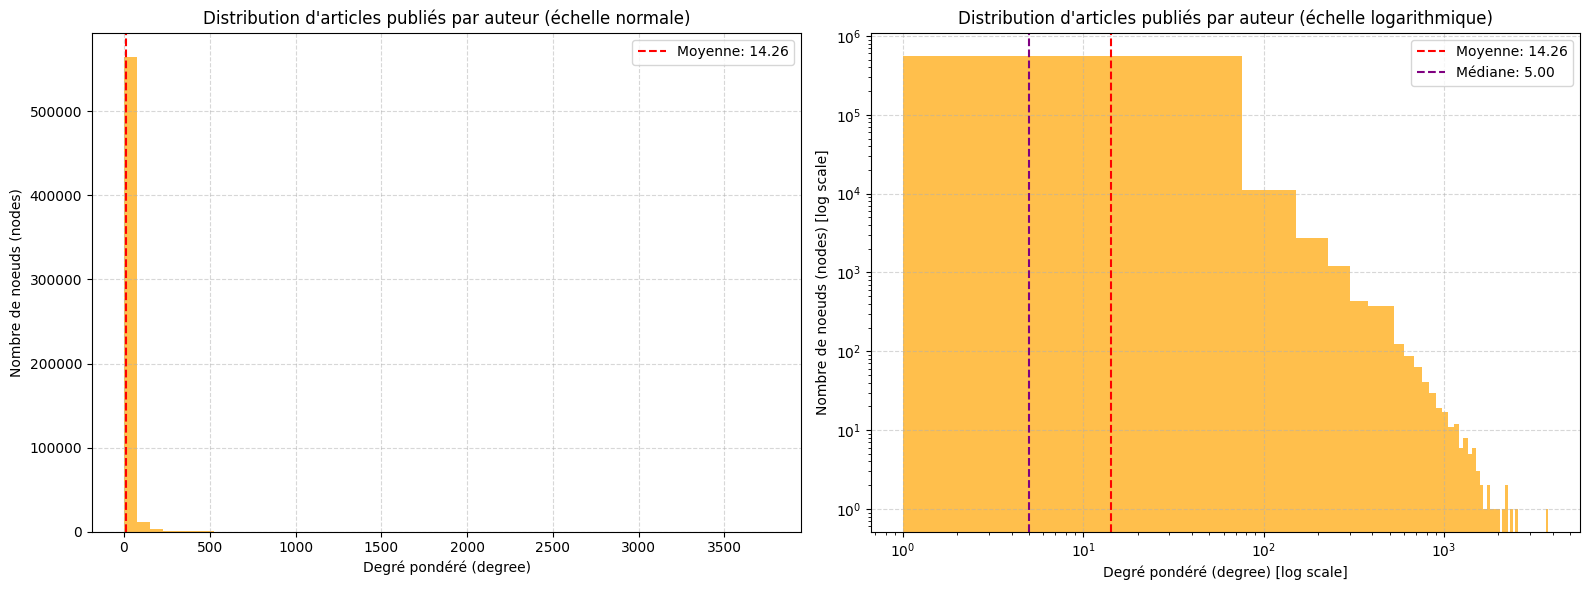

In [ ]:
distr_nodes_degree(G_science, w=True)

In [4]:
#Ajouter l'attribut primary_category à tout les noeuds
primary_cat = add_node_attribut_primary_cat(G_science)

In [ ]:
edge_max(G_science)

Les deux auteurs connectés par l'arête de poids maximal (124) sont : 'Ciriaco Andrea D'Angelo' et 'Giovanni Abramo'
Leur degré, càd le nombre de publications est : 230, 226
leur catégorie principale:
cs cs


### Communautés avec Louvain et création d'un nouveau attribut

In [ ]:
communities, membership = louvain_attribut(G_science, res=1.0)


# Save the vraible communities in a pickle file for later use
with open('communities_list.pkl', 'wb') as f:
    pickle.dump(communities, f)

with open('membership_list.pkl', 'wb') as f:
    pickle.dump(membership, f)

Number of communities: 21062



- Build a node-->community mapping so that membership is a dict with all the 703614 nodes and each node
is asociated with its community (from 1 to 30890)

    - membership = {
    'John Kirchenbauer': 0,
    'Tom Goldstein': 0,
    'Inbar Seroussi':  1,
    .....
    'Blake Bordelo':   30890}

- Then we add a new node attribute called "louvain_community" to each node of the graph so that we can access to the community of each person like this 
    - G_science.nodes['Inbar Seroussi']['louvain_community']

In [ ]:
import pickle

with open('communities_list.pkl', 'rb') as f:
    communities = pickle.load(f) 
with open('memership_list.pkl', 'rb') as f:
    memership = pickle.load(f)

### Visualisation avec Pyvis (interactive)
Noeuds et edges seront coloriés selon la communauté à laquelle ils appartiennent

In [ ]:
G_maths =  nonDirected_graph("testpas_cs__petit_echantillon.csv", filter_weight=0) #testpas_cs__petit_echantillon.csv a 2100 lignes
communities_test, membership_test = louvain_attribut(G_maths, weight='weight', resolution=1.0) 
visualize_with_pyvis(G_maths, "maths_graph.html")

Number of nodes: 1877
Number of edges: 2100
maths_graph.html


<class 'pyvis.network.Network'> |N|=1877 |E|=2,100

## Structure

### Analysis of the created communities

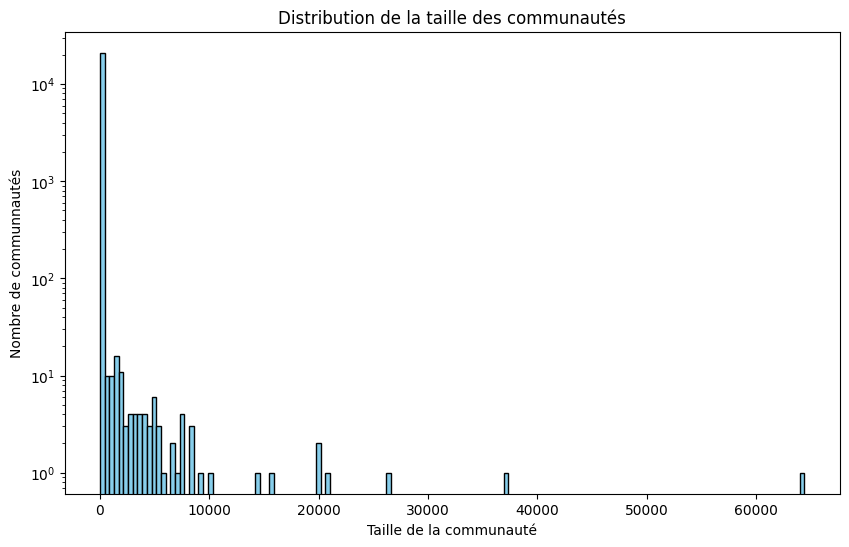

In [ ]:
density_hist_comm_size(membership)

L’algorithme de Louvain calcule la modularité, qui mesure la densité des liens au sein d’une communauté comparée à celle entre communautés. Lorsqu’elle n’augmente plus, il regroupe les nœuds d’une même communauté en un super-nœud. Le graphe est alors réduit à un plus petit nombre de super-nœuds, et on répète ce processus itérativement jusqu’à ce qu’aucune amélioration de la modularité ne soit possible.
- Analyse descriptive du graphique:
  - Un pic écrasant sur la toute première barre (communautés de taille 1 ou 2) : la **<span style="color: orange;">grande majorité des communautés regroupent <10 auteurs**. Correspondent sans doute à des binômes ou trinômes de recherche très spécialisés.
  - Une queue très longue : quelques dizaines de communautés de taille intermédiaire (quelques milliers d’auteurs).
  - **<span style="color: orange;">Deux grosses communautés** en bout de queue (> 50 000 et > 90 000 nœuds) qui concentrent **<span style="color: orange;">¼ du réseau**. On peut penser que ce ne sont pas des équipes de chercheurs soudées, ce sont des collaborations ponctuelles ou rares. Peut être formé de doctarants qui n’ont collaboré que quelques fois, leur carrière vient de commencer. Peut être aussi de co-auteurs de publications massives, ils font partie de publications avec des dizaines d’auteurs, ils sont responsables d’une petite partie de l’article et ils n’ont aucune relation avec la plupart des co-auteurs de l’article.
- On peut choisir la taille de nos communautés via l’hyper-paramètre “résolution”
  - Valeurs plus élevées → plus de communautés, communautés plus petites et plus serrées
  - Valeurs plus faibles → moins de communautés, plus grandes
    - Avec resolution = 1 on obtient 30 890 communautés
    - Avec resolution = 0,5 on obtient 30 973 communautés
    
- Ce résultat semble bizarre, **<span style="color: orange;">on a diminué la résolution et pourtant il a crée 83 communautés de plus** (sur 31 000 communautés ce nombre est négligeable mais reflète la sensibilité de Louvain et nous montre encore une fois la sparsité et la dispersion de notre réseau.)
  - Dans notre cas, sur 30 000 communautés, la quasi-totalité sont des micro-groupes de <10 noeuds, ils ne changent donc pas quel que soit la  résolution, puisqu’il n’y a pas assez de poids d’arêtes pour justifier leur fusion
  - Seules quelques communautés plus grandes bougent réellement avec la résolution. Donc le nombre total de clusters reste à peu près constant, et une variation de quelques dizaines est tout à fait normale.
  - À deux valeurs de de la résolution différentes, on peut tomber sur deux maxima locaux distincts, qui ne respectent pas forcément une relation strictement monotone du nombre de clusters. On va vérifier cela en traçant le nb de communautés vs la résolution pour voir l'impacte du changement de la résolution.

- **Intuition sur la structure de notre graphe**:
    - graphe très hétérogène : beaucoup d’auteurs n’ont qu’une ou deux collaborations.
    - Avec un **<span style="color: orange;">γ petit, deux nœuds reliés par une seule arête n’apportent pas assez de gain de modularité** pour être fusionnés ; ils restent donc séparés → **<span style="color: orange;">explosion du nombre de communautés**.
    - Les communautés « réelles » (densément connectées) ne se forment qu’à partir d’un certain seuil de γ où la fusion devient rentable.

- Piste: Augmenter la modularité pour capturer des communautés plus faibles au sein de ce méga-cluster ou bien faire le contraire, diminuer la modularité et essayer de rassembler dans des méga-noeuds les petites commuautés
Conclusion 2: à compléter quand j’aurais tourné Louvain avec une modularité plus basse


##### Analyse des profils d'auteurs dans les plus petites communautés

In [3]:
communities, membership = louvain_attribut(G_science, res=1.0)

Number of communities: 21036


Nombre de petites communautés (<10): 20223
Nombre de communautés denses (densité > 0.99): 16638
Probabilité (fréquence) d'être dense : 82.27%
threshold: 0.99


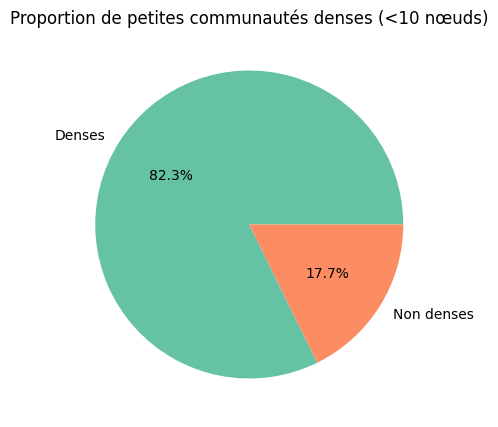

In [4]:
are_little_comms_dense(G_science,communities,membership, 0.99)

20 233/ 21 062 = 0.96. Donc **<span style="color: orange;">96% des communautés ont moins de 10 auteurs**.

La densité d’un graphe (ou d’un sous-graphe) mesure à quel point **ses nœuds sont reliés entre eux comparativement au nombre maximal d’arêtes possibles**. Pour ce graphe non orienté de 𝑛 nœuds et 𝑚 arêtes, la densité 𝛿 est: 2m/(n(n-1))

- Si 𝛿=0, il n’y a aucune connexion entre les nœuds.
- Si 𝛿=1, chaque nœud est connecté à tous les autres (graphe complet).
   - Dans le graphique ci-dessus, **on considère une communauté dense si 𝛿>0.99**

**Interprétationde notre résultat**

Une communauté dense signifie que presque tous les auteurs de ce groupe interagissent directement entre eux.

À l’inverse, une communauté peu dense regrouperait plutôt des auteurs qui ne collaborent que marginalement.

92% de nos petites communautés Louvain sont denses, ce qui nous mène à penser que :

- Il y a un fort niveau de spécialisation et cohésion, les auteurs au sein de chaque petite communauté partagent très probablement un même champ de recherche très pointu. 
- Les membres d’une même communauté ont des trajectoires et des centres d’intérêt semblables (même laboratoires, mêmes méthodologies, mêmes thématiques).
- Les communautés sont des **réseaux fermés** : l’information et les collaborations circulent surtout à l’intérieur, avec peu d’ouvertures vers l’extérieur.

0% de nos grandes communautés Louvain sont denses avec threshold=0.5:
- La moitié des auteurs des communautés ne sont pas connectés entre eux

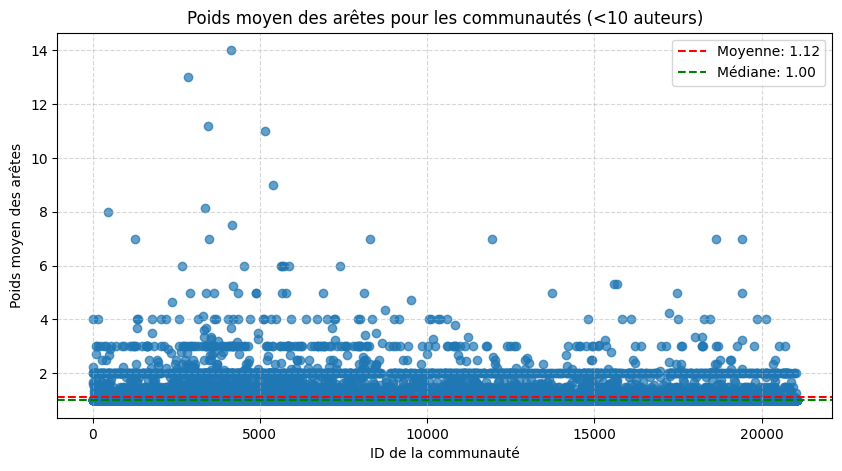

In [ ]:
# Calculer le poids moyen des arêtes pour les communautés de plus de 100 auteurs
mean_edges_weight(G_science, communities, 10, little=True)

##### La plus grande communauté


Nombre de petites communautés (<10): 111
Nombre de communautés denses (densité > 0.99): 0
Probabilité (fréquence) d'être dense : 0.00%
threshold: 0.99


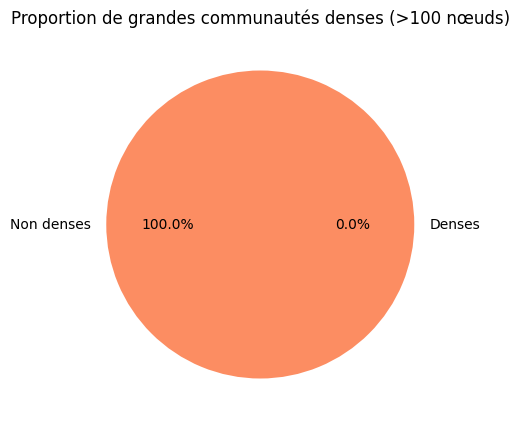

In [5]:
are_big_comms_dense(G_science, communities, membership, 0.5)

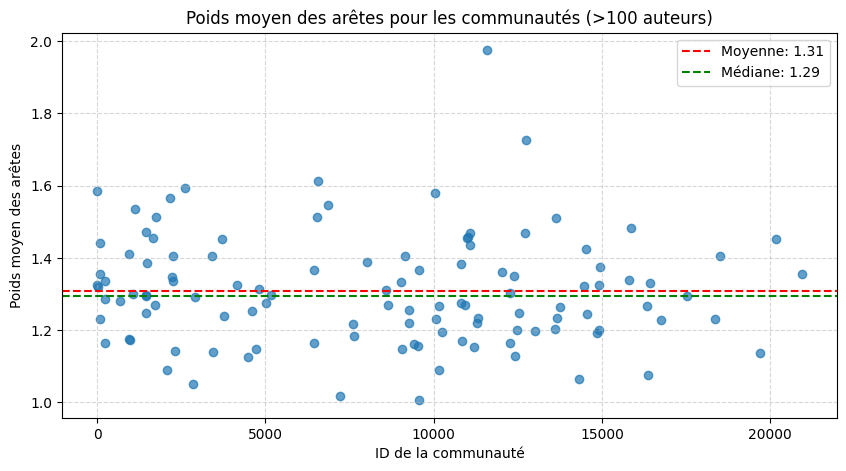

In [ ]:
mean_edges_weight(G_science, communities, 100, little=False)

Avec ces deux graphiques, onn relève une information très importante:
- Dans les petites comme dans les grandes communautés, la moitié des arêtes ont poids 1, càd que la moitié des pairs d'auteurs n'ont collaboré qu'une fois. Ceci est relevé par la médiane.
- Or, dans les petites communautés, la moyenne des poids varie entre 1 et 14. Ceci implique qu'au sein de certaines communautés, les auteurs on collaboré plus de 10 fois entre eux. Ce sont des communautés plus denses, des collaborations qui dirent dans le temps et des équipes qui publient souvent ensemble
- Par contre, même si la médiane reste la même, la moyenne des poids dans les grandes communautés ne varie que entre 1 et 1.8. Ceci indique que les grandes communautés sont constituées d'auteurs qui publient rarement ensemble. Ceci peut etre du à:
   - des auteurs de machine learning puisque les articles de ce domaine ont souvent des dizaines d'auteurs
   - des auteurs jeunes qui n'ont que sa première publication sur Arkiv
   - des articles en preprint qui seront enlevés dès publication en magazine officielle et qui seront supprimés d'arkiv après

Ci-dessous on remarque que la communauté plus grande est composée de 64 416 auteurs asiatiques

In [ ]:
# Trouver la communauté avec le plus de nœuds
largest_community = max(communities, key=len)

# Afficher les auteurs de cette communauté
print(f"Nombre d'auteurs dans la plus grande communauté : {len(largest_community)}")
print("Auteurs dans la plus grande communauté :")
for author in largest_community:
    print(author)

In [14]:
import random

# `communities` is my list of sets from louvain_communities
n_comms = len(communities)

# 1. Pick 3 distinct community indices
chosen_ids = random.sample(range(n_comms), 6)

for cid in chosen_ids:
    comm_nodes = list(communities[cid])
    # 2. Sample up to 20 authors (if the community has fewer than 20 nodes, sample all)
    sample_authors = random.sample(comm_nodes, min(20, len(comm_nodes)))
    # 3. Print them
    print(f"\nCommunity #{cid} (size {len(comm_nodes)}):")
    for a in sample_authors:
        print("  ", a, ":", G_science.nodes[a]['primary_category'])



Community #10112 (size 9):
   Hans Zachary N : cs
   Sharma Anuj : cs
   Neal R : cs
   Ravichandra-Mouli Varsha : cs
   Kandiboina Raghupathi : cs
   Knickerbocker Skylar : cs
   Kojo Adu-Gyamfi : cs
   Hawkins : cs
   Adu-Gyamfi Kojo : cs

Community #3373 (size 2):
   A. P. Starovoitov : math
   I. V. Kruglikov : math

Community #2077 (size 2):
   Francisco Redelico : stat
   Francisco Traversaro : stat

Community #17138 (size 4):
   Robert Akinie : cs
   John Kelly : cs
   Nana Kankam Brym Gyimah : cs
   Mansi Bhavsar : cs

Community #16210 (size 4):
   Swati Chowdhuri : cs
   Samadrita Karmakar : cs
   Satadip Saha : cs
   Ankur Chanda : cs

Community #13531 (size 3):
   Gordan Krekovic : cs
   Dejan Grba : cs
   Antonio Poscic : cs


- Community #10475 (size 3):
    - A M Mathai: indian, McGill University 
    - Joy Jacob: indian, Cochin University of Science & Technology
    - Sebastian George: indian, Kannur University

- Community #30570 (size 4):
    - Kiran Mantripragada: Indian, Ontario Tech University​
    - Shima Rezasoltani: Iranian, Ontario Tech University​
    - Faisal Z. Qureshi: Pakistani, Ontario Tech University​
    - Soham Chitnis: Indian, New York University

- Community #12908 (size 3):
    - Delphine Boucher: French, University of Rennes 1​
    - Félix Ulmer: French, University of Rennes 1​
    - Willi Geiselmann: German, Karlsruhe Institute of Technology

- Community #30765 (size 2):
    - Matthew Barth: American, University of California, Riverside​
    - Saswat Priyadarshi Nayak: Indian, University of California, Riverside​

- Community #14505 (size 12):
    - S. Pfenninger: Swiss, Delft University of Technology ​
    - S. Zachary: Information not found​
    - I. Staffell: British, Imperial College London ​
    - K. Schell: American, University of San Francisco ​
    - S. H. Tindemans: Dutch, Delft University of Technology ​
    - M. Lynch: American, Arizona State University ​
    - H. Zareipour: Canadian, University of Calgary ​
    - A. L. Wilson: American, University of Tennessee ​
    - S. Awara: American, National Renewable Energy Laboratory ​
    - R. Sioshansi: American, Carnegie Mellon University ​
    - C. J. Dent: Information not found​
    - N. Samaan: American, Pacific Northwest National Laboratory

- Community #47 (size 2):
    - S. Nechaev: Russian, Lomonosov Moscow State University ​
    - K. Polovnikov: Russian, Lomonosov Moscow State University

- Community #15142 (size 13):
    - Grylia Yaneth Chata Iscarra: Peruvian, Universidad Nacional del Altiplano​
    - Josefh J. Quispe-Morales: Peruvian, Universidad Nacional del Altiplano​
    - Nadine Aceituno-Moya: Peruvian, Universidad Nacional del Altiplano​
    - Lindell Dennis Vilca-Mamani: Peruvian, Universidad Nacional del Altiplano​
    - Cliver W. Vilca-Tinta: Peruvian, Universidad Nacional del Altiplano ​
    - Henry Juarez-Vargas: Peruvian, Universidad Nacional del Altiplano ​
    - Yhack Bryan Aycaya-Paco: Peruvian, Universidad Nacional del Altiplano​
    - Wladimir A. Carlosviza-Amanqui: Peruvian, Universidad Nacional del Altiplano​
    - Luz B. Valenzuela-Narvaez: Peruvian, Universidad Nacional del Altiplano​
    - Roger Mijael Mansilla-Huanacuni: Peruvian, Universidad Nacional del Altiplano​
    - Tony Gabriel-Fernandez Cayo: Peruvian, Universidad Nacional del Altiplano​
    - Rubi Melania Coasaca Callacondo: Peruvian, Universidad Nacional del Altiplano

Ainsi, nous pouvons clairement voir que les communautés ont regroupé des personnes du même pays, qui recherchent dans le même domaine, mais aussi que les personnes d'une même communauté proviennent souvent de la même université (cette dernière information a été recherchée sur Internet car l'université ou le pays ne sont pas des informations présentes dans la base de données).



### Structure de petit monde?

- En laissant de côté les communautés crées par Louvain, revenons à la structure de notre graph de base

  - On a vu qu’il y a deux gros méga–cluster, relié par d’innombrables liens de poids 1–2. Ces liens faibles ont le role de conecter différentes petites communautés denses, ce qui est justement la clef des réseaux « petit monde » (chemins courts + forte cohésion locale).
  - La composante géante est un critère purement topologique (connexion vs non-connexion), c’est la plus grande sous-partie du graphe dans laquelle chaque paire de nœuds est reliée par au moins un chemin.
  - Mais vu qu’on a plein de binomes connectés, il y a **<span style="color: orange;">que la plus grande composante connexe qui peut etre un petit monde**.
  - La relative du plus grand composant connexe :507 595 / 581 712 = 0.8726, càd **<span style="color: orange;">87% des noeuds de notre graphe forment un réseau où il y a au moins un chemin pour aller d'un auteur random quelconque à un autre**.
  - en moyenne, les arêtes de ce sous-graphe connexe ont un poids de 1.3 (faible)

- Explication/intuition: Dans un réseau ordonnée le C et le L sont élevés, dans un réseau construit de manière totalement random C et L sont très faibles, dans un petit monde, C est élevé et L est faible. On va donc étudier C et L pour la grande composante connexe. Comment?
    - Extraire la plus grande composante connexe de notre graphe. Calculer C = coefficient de clustering moyen et L = longueur moyenne des plus courts chemins. Puis construire un graphe aléatoire de même taille et même distribution de degrés, et calculer C_rand et L_rand pour celui-là. On comparera les résultats. 
      - Si C/C_rand>=1 (ici testé>10) pour s’assurer d’une forte cohésion locale.
      - L/L_rand ≈ 1 (ici tolérance 0.5–2) pour vérifier que les distances globales restent courtes.

In [6]:
Gg = first_analysis_giant_connected_component(G_science)

Taille relative du plus grand composant connexe :507595 / 581712 = 0.8726
Moyenne des poids des arêtes de la composante géante : 1.3044


### Rôles

1. Chercher des ponts en utilisant la catégorie primaire
- D'abord on a fait pour chaque nœud, calculer un score: combien de ses arrêtés sont dans une catégorie différente que sa catégorie primaire. Pour chacune des 4 categories: maths, stats, eco, cs, on prend l’auteur avec un plus grand score. Intuitivement, cela mesure à quel point un auteur est **“<span style="color: orange;">interdisciplinaire</span>”**. 
- **MAUVAIS** choix: on a juste les auteurs plus polyvalents de chaque catégorie, pas forcément ceux qui ont le rôle de pont entre une catégorie et une autre.

2. Chercher des ponts en utilisant la centralité intermédiaire
 - On va donc utiliser la centralité d'intermédiarité **<span style="color: orange;">betwenness</span>**: calculer le plus court chemin ente tout les noeds puis calcule combien passent par ce noeud. Un auteur avec une betweenness élevée relie beaucoup de paires d’auteurs : c’est typiquement un « pont » entre groupes, voire entre communautés. On va définir une personne **pont** un auteur parmi les auteurs dont la communauté primaire est A, ceux qui ont le plus de voisins dans la communauté B et une betweenness élevée.
 - Pour chaque paire de catégories, on balaie tous les auteurs de A, on compte leurs voisins dans B et on regarde leur betweenness globale.
 - On choisit celui qui maximise d’abord le nombre de voisins dans B, puis, en cas d’égalité, la betweenness.


In [ ]:
plyvalent_authors_by_category(G_science, primary_cat)

In [ ]:
# cette fonction a une compléxité O(n²) donc peut être très longue
bridge_authors_by_centrality(G_science, primary_cat)

### Centralité

##### Chercher des leaders de deux manières différentes

- Degré : extrait le sous-graphe de chaque catégorie et prend le nœud de degré pondéré maximal.
- Betweenness : même chose mais avec la mesure de betweenness sur chaque sous-graphe.

In [ ]:
leaders_deg, leaders_btw = leaders_by_category(G_science, primary_cat, degree=True, betw=False )

##### Plus court chemin
1. Technique: on échantillonne 1000 paires, on calcule la plus courte distance, on plot la distribution des distances et on fait la moyenne. Pour:
- Auteur aléatoire ↔ auteur aléatoire dans la meme catégorie
- Distance moyenne entre deux auteurs random dans toutes les categories
2. Analyse du degré de séparation pour la grande composante
- On prends 10 auteurs de départ au **hasard** dans la **grande composante connexe**
- On regarde combien de voisins il a. Ce nombre de voisins sera le nombre d'auteurs cumulés au degré 1
- On regarde les voisins des auteurs de degré 1 et on regarde combien d'auteurs différents on a atteint. Ce nombre de voisins plus ceux qu'on avait déjà sera le nombre d'auteurs cumulés au degré 2.
- On fait ainsi jusqu'à 10 et on regarde combien d'auteurs on a atteint en 10 degrés

Dans la figure ci-dessous on observe que pour les 10 démarrages aléatoires, **<span style="color: orange;">au bout de 10 degrés de séparation</span>** on atteint plus de 500 000 auteurs. Sachant que la composante géante contient 507 595 auteurs, cela veut dire que on atteint **<span style="color: orange;">tout le monde</span>**. Avec ce qui précède on peut conclure que pour le 87% des auteurs du graphe initial, il y a un chemin de 10 auteurs qui relie n'importe quelle paire d'auteurs.

C'est une caractéristique de petit monde (connecté). Néanmoins, on remarque que le **<span style="color: orange;">degré de séparation de ce réseau est beaucoup plus élevé que celui des humains</span>** (environ à 6) et que celui de Facebook (environ à 4). Ceci est naturellement logique parce que, disons le de cette manière, un chercheur a beaucoup moins de collègues que d'amis.

In [ ]:
# complexité O(n²) donc peut être très longue
import random
import matplotlib.pyplot as plt
import networkx as nx
all_nodes = list(G_science.nodes())
sample_nodes = set(random.sample(all_nodes, 200000))
# Création du sous‐graphe induit (et copie pour avoir un graphe indépendant)
G_sub = G_science.subgraph(sample_nodes)
primary_cat = add_node_attribut_primary_cat(G_sub)
leaders_deg = leaders_by_category(G_sub, primary_cat, degree=True, betw=False )
analyze_distance_distributions(G_sub, primary_cat, leaders_deg, n_samples=1000)


>>> Leaders par degré (catégorie: auteur, degré_pondéré)
        cs : 'Rui Zhang', degré=753
      econ : 'Lais Miachon', degré=21
      math : 'Saharon Shelah', degré=271
   math-ph : 'Wen-Li Yang', degré=31
      stat : 'Fan Li', degré=68


TypeError: object of type 'NoneType' has no len()

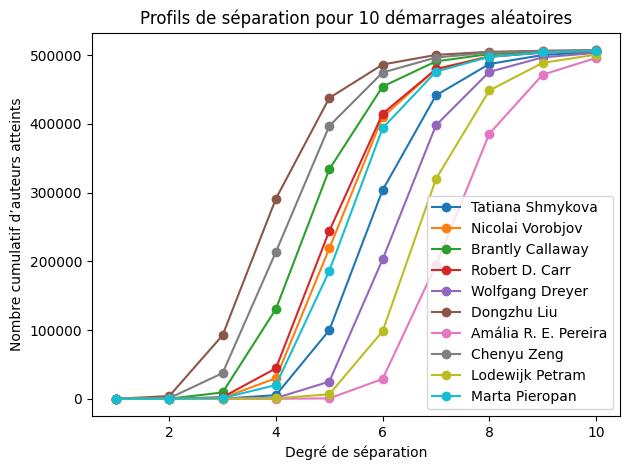

In [ ]:
profiles = run_random_separation(G_science, runs=10, max_deg=10, seed=42, plot=True)

##### Transitivité

In [5]:
# complexité O(n²) donc peut être très longue
primary_cat = add_node_attribut_primary_cat(G_science)
transitivity_by_category(G_science, primary_cat)


>>> Transitivité (2m/[n(n-1)]) par catégorie
        cs : 0.4592
      econ : 0.8715
      math : 0.2735
   math-ph : 0.4969
      stat : 0.5618


In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx





G_sub = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))

C_real = nx.average_clustering(G_sub) #Transitivité
L_real = nx.average_shortest_path_length(G_sub)

# Build an ER random graph with same n and p = 2m/[n(n−1)]
n, m = G_sub.number_of_nodes(), G_sub.number_of_edges()
p = 2*m/(n*(n-1))
# ensure connectivity by re-sampling until it’s connected
while True:
    R = nx.gnp_random_graph(n, p)
    if nx.is_connected(R):
        break

C_rand = nx.average_clustering(R)
L_rand = nx.average_shortest_path_length(R)

sigma = (C_real/C_rand) / (L_real/L_rand)
print(f"Small-world σ ≃ {sigma:.3f}  (σ≫1 ⇒ small-world)")